<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/Ayoub_straightcrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

2019.2.0.dev0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Geometry


Lx = 1; Ly = 3.
h = .3; a = .2 


plate = Rectangle(Point(-Lx/2, -Ly/2), Point(Lx/2, Ly/2))

notchVertices = [Point(-Lx/2, -a/2), Point(-Lx/2 +h , 0.), Point(-Lx/2 , a/2)]
notch = Polygon(notchVertices)

domain = plate - notch

cellSize = .05
nel = Lx / cellSize
mesh   = generate_mesh(domain, nel)


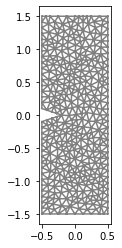

In [ ]:
plot(mesh)

In [ ]:
ndim = mesh.topology().dim()

cell_mrk = MeshFunction('bool', mesh, ndim)
cell_mrk.set_all(False)

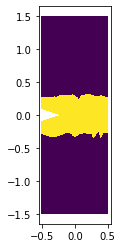

In [ ]:
ref_threshold = 0.3

for cell in cells(mesh):
  if -ref_threshold < cell.midpoint()[1] < ref_threshold:
    cell_mrk[cell] = True

plot(cell_mrk)


meshFine = refine(mesh, cell_mrk)
# mesh = refine(mesh, cell_mrk)


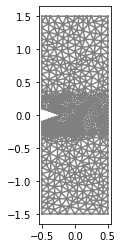

In [ ]:
plot(meshFine)

In [ ]:
# Functional setting


V_u = VectorFunctionSpace(mesh, 'CG', 1)
V_alpha = FunctionSpace(mesh, 'CG', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)

alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)


In [ ]:
# Boundary conditions

ut = Expression('t', t=0., degree=0)

bcs_u = [DirichletBC(V_u.sub(1), ut, 'near(x[1], {}, 1e-5)'.format(Ly/2)), 
         DirichletBC(V_u.sub(1), Constant(0.), 'near(x[1], {}, 1e-5)'.format(-Ly/2))]



bca_0 = DirichletBC(V_alpha, Constant(0.), 'near(x[1], {}, 1e-5)'.format(Ly/2))
bca_1 = DirichletBC(V_alpha, Constant(0.), 'near(x[1], {}, 1e-5)'.format(-Ly/2))

bc_alpha = [bca_0, bca_1]

In [ ]:
# Constitutive

# Constitutive functions

E, nu = Constant(1.), Constant(.0)
Gc = Constant(1.)
ell = Constant(0.1)

ndim = mesh.topology().dim()

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return 2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim)

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [ ]:
import sympy

s = sympy.Symbol('s')
cw = float(sympy.integrate(4*sympy.sqrt(w(s)), (s, 0, 1)))


tmp = 2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})

print("Gc = %2.3f"%((ell*cw)/tmp))

Gc = Constant((ell*cw)/tmp)

Gc = 0.267


In [ ]:
# Energetics


elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy = Gc/cw * (w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)



In [ ]:
# Solve displacement problem, using automated derivative, and autmated 
# construction of linear and bilinear forms

# problem_u = LinearVariationalProblem()
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bcs_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

# Alternatively, compute explicitly:

A = inner(sigma(alpha, du), eps(v))*dx
# f0, g0 exist in L^2(\Omega), L^2(\partial\Omega)
# L = dot(f0, v)*dx + dot(g0, v)*ds
zero = project(Constant((0., 0.)), V_u)
L = dot(zero, v)*dx

problem_u = LinearVariationalProblem(A, L, u, bcs_u)


In [ ]:
# u = TrialFunction(V_u)
ut.t = .1
solver_u.solve()

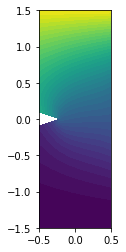

In [ ]:
# dir(plot, mo)
plot(dot(u,u))

In [ ]:
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

# bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
# bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

# bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_alpha, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                                 }
                                }


# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)

solver_alpha.solve()




(0, True)

In [ ]:
# boundaries

In [ ]:

def alternate_minimisation(alpha, u,
                           alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100):
  alpha_diff = Function(V_alpha)
  iter = 1; error = 1
  alpha.vector()[:] = alpha_0.vector()
  
  while iter < maxiter and error > tol:
    solver_u.solve()
    # u: solution

    solver_alpha.solve()
    # alpha: solution
    # alpha0: alpha at previous timestep

    alpha_diff.vector()[:] = alpha.vector() - alpha_0.vector()
    error = norm(alpha_diff.vector(), 'l2')
    print("Iteration %d, error %e, alpha_max=%.3f"%(iter, error, max(alpha.vector())))
    alpha_0.assign(alpha)

    iter = iter+1

  return (iter, error)

In [ ]:
# alpha = Function(V_alpha)
# ut.t = 4.
# alternate_minimisation(alpha, u)

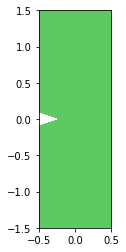

In [ ]:
plot(alpha)

In [ ]:
def postprocess()

In [ ]:

forces[i_t] = np.array([t,assemble(sigma(u,alpha)[1,1]*ds(1))])

In [ ]:
# Evolution monotonically increasing load

loads = np.linspace(.0, 2.5, 30)

energies = []

tot_en = []
sur_en = []
ela_en = []

for (i, t) in enumerate(loads):
  ut.t = t
  print("** load step: t=%.2f"%t)
  alternate_minimisation(alpha, u, maxiter=200)
  lowerbound.vector()[:] = alpha.vector()
  # postproc
  tot_en.append(assemble(total_energy))
  sur_en.append(assemble(dissipated_energy))
  ela_en.append(assemble(elastic_energy))
  print("** elastic = {:.3f}, surface = {:.3f}, total = {:.3f}".format(ela_en[-1], sur_en[-1], tot_en[-1]))


energies = {'elastic': ela_en, 'surface': sur_en, 'total': tot_en}



** load step: t=0.00
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.000, surface = 0.000, total = 0.000
** load step: t=0.09
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.001, surface = 0.000, total = 0.002
** load step: t=0.17
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.004, surface = 0.000, total = 0.005
** load step: t=0.26
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.010, surface = 0.000, total = 0.011
** load step: t=0.34
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.018, surface = 0.000, total = 0.018
** load step: t=0.43
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.028, surface = 0.000, total = 0.028
** load step: t=0.52
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.040, surface = 0.000, total = 0.041
** load step: t=0.60
Iteration 1, error 0.000000e+00, alpha_max=0.042
** elastic = 0.055, surface = 0.000, total = 0.055
** load step: t=0.69
Iteration 1

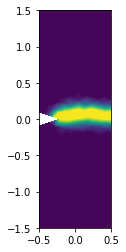

In [ ]:
plot(alpha)

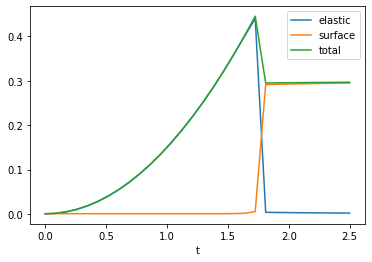

In [ ]:
plt.plot(loads, energies['elastic'], label = 'elastic')
plt.plot(loads, energies['surface'], label = 'surface')
plt.plot(loads, energies['total'], label = 'total')
plt.legend()
plt.xlabel('t')
# plt.ylabel('Energies')
tc = sympy.sqrt(2*(sympy.diff(w(s),s)/sympy.diff(1/a(s),s)).subs({"s":0})/E)

# plt.xticks([0., tc], labels = ['0', '$t_c$'])

